### mm_synchrony

This function computes group statistics on synchrony results (across electrodes)

[] load data from both clusters

[] create a Class object that contains a pair of electrode lists (EEG, metadata)

[] get list of subjects

[] for each subject, get a list of electrodes from each group

[] loop through the lists such that all  pairs are matched up

[] collect synchrony data across task, freq, time for each pair

[] plot

[] stats

In [1]:
# import packages
import numpy as np # numpy
import pandas as pd # pandas
from scipy import stats
import mm_func
import mne
import pycircstat as circ
from mne import time_frequency
from fooof import FOOOF
from pylab import * 
%matplotlib inline
import os

In [2]:
# set params
# define parameters for analyses as a dictionary
params = {'rejection_thresh_sd':20,
          'event_type':'move',
          'time_window_ms_wave':(-1800,1800),
          'time_window_ms_pre':(-500,-100),
          'time_window_ms_post':(100,500),
          'buffer_ms_wave':1000,
          'frange_wave':(3,8),#3,120
          'numfreqs_wave':6,
          'HFA_range':(70,120),
          'theta_range':(3,8),
          'alpha_range':(10,12),
          'beta_range':(12,30),
          'gamma_range':(30,50)} 
# fig path
figpath = '/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/synchrony/'
print(figpath)

# make directory if it doesnt exist
if os.path.exists(figpath) == False:
    os.makedirs(figpath)
    

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/synchrony/


In [3]:
# load data
#load data from Cluster 3
[EEG_c3,metadata_c3] = mm_func.loadEEG(clusId=3)

#load data from Cluster 1
[EEG_c1,metadata_c1] = mm_func.loadEEG(clusId=1)


#load data from Cluster 2
[EEG_c2,metadata_c2] = mm_func.loadEEG(clusId=2)




/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-3.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 3 = 46
REPLACING Contact 13 field anat with NONE
Done loading Cluster 3
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-1.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 1 = 38
REPLACING Contact 0 field anat with NONE
REPLACING Contact 1 field anat with NONE
REPLACING Contact 10 field anat with NONE
REPLACING Contact 13 field anat with NONE
REPLACING Contact 31 field anat with NONE
Done loading Cluster 1
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosu

In [10]:
class SynchronyGroup:
    
    def __init__(self,EEG,metadata,EEG_other,metadata_other,params):
        self.EEG = EEG
        self.metadata = metadata
        self.EEG_other = EEG_other
        self.metadata_other = metadata_other
        
        # set params
        self.event_list = ['wait','inst','move']
        self.toi_list = ['pre','post']
        self.foi_list = ['theta','alpha','beta','gamma','HFA']
        self.rejection_thresh_sd = params['rejection_thresh_sd']
        self.time_window_ms_wave = params['time_window_ms_wave']
        self.time_window_ms_pre = params['time_window_ms_pre']
        self.time_window_ms_post = params['time_window_ms_post']
        self.buffer_ms_wave = params['buffer_ms_wave']
        self.frange_wave = params['frange_wave']
        self.numfreqs_wave = params['numfreqs_wave']
        self.HFA_range = params['HFA_range']
        self.theta_range = params['theta_range']
        self.alpha_range = params['alpha_range']
        self.beta_range = params['beta_range']
        self.gamma_range = params['gamma_range']
        
        
        # initialize containers
        self.subj_self = [] #  identifier for first contact
        self.subj_other = [] # identifier for second contact
        self.uElbl_self = [] #  identifier for first contact
        self.uElbl_other = [] # identifier for second contact
        self.roi_self = [] #  identifier for first contact
        self.roi_other = [] # identifier for second contact
        self.pairElbl = [] # identifier for pair
        self.roi_pair_lbl = [] # identifier for roi pairs
        self.roi_pair_count = [] #for count in each roi pair
        for t in arange(0,len(self.toi_list)):
            for f in arange(0,len(self.foi_list)):
                for e in arange(0,len(self.event_list)):
                    # initialize ralZ (for pairRaleigh Z statistic)
                    setattr(self,'ralz_'+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t],[])
                    
                    # initialize mean ralZ (for mean ral Z statistic)
                    setattr(self,'meanralz_'+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t],[])



                    
    def append_PLV_local(self,E,event_type,params):
        """This function appends PLV data from an electrode to the containers in self.
        Used in pairwise synchrony function below
        Inputs: 
        E -instande of electrode class with E.getEEG and E.calcPhase (and phase diff if needed) already calculated 
        event_type: move vs. wait vs. inst
        params: needs freq ranges (e.g., ['theta_range']:(3,8) and time_window_pre and post)"""
        
        # loop through time of interes (toi) and freq of interest (foi) labels
        for t in arange(0,len(self.toi_list)):
            for f in arange(0,len(self.foi_list)):
                
                # for each interation, update the PLV for E using these foi and toi params   
                E.calcPLV(params[self.foi_list[f]+'_range'],params['time_window_ms_'+self.toi_list[t]])

                # append container array
                # get current array
                x = getattr(self,'ralz_'+event_type+'_'+self.foi_list[f]+'_'+self.toi_list[t])

                # append new PLV value 
                #x = np.append(x,E.PLV_rvl) # use resultant vector length
                x = np.append(x,E.PLV_z) #(use Raleigh test z-statistic)

                #store new array in container
                setattr(self,'ralz_'+event_type+'_'+self.foi_list[f]+'_'+self.toi_list[t],x)                
    def calcMeanRalZ_roi(self):
        """ This function calculates the mean Raleigh Z statistic for each ROI based on the results of the
        pairwise synchrony result from the function below."""
        
        #get contact list
        roi_list = np.unique((self.roi_self,self.roi_other))
        
        # counter
        count = -1
        
        # initialize containers
        roi_pair_lbl = []
        roi_pair_count = []
        
        # loop through contact list
        for x in arange(0,len(roi_list)):
            for y in arange(0,len(roi_list)):
                
                #update count
                count+=1
                
                # identify this roi (self)
                roi_self = roi_list[x]   
                
                # identify this roi (other)
                roi_other = roi_list[y]  
                
                # identify roi-pair
                np.append(roi_pair_lbl,roi_self+'-'+roi_other)
                
                print(roi_pair_lbl)
                print(count)
                print('about to bug..')
                
                #get index of all pairs including this contact 
                idx = (self.roi_self==roi_self)&(self.roi_other==roi_other)
                
                # count n obs in this pair
                np.append(roi_pair_count,sum(idx))         
            
                
                # loop through each event_type,time_window and freq of interest and update mean ralZ
                for t in arange(0,len(self.toi_list)):
                    for f in arange(0,len(self.foi_list)):
                        for e in arange(0,len(self.event_list)):
                          
                            # initialize mean ralz_roi  (for pairRaleigh Z statistic)
                            setattr(self,'meanralz_roi_'+roi_pair_lbl[count]+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t],[])
                            
                            if sum(idx)>0: # if there are observations in this pair
                                # get mean ralZ _roi
                                x = getattr(self,'meanralz_roi_'+roi_pair_lbl[count]+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t])

                                # get pairwise ral_z
                                x_pairs = getattr(self,'ralz_'+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t])

                                # calc mean of pairwise ralz and append it to mean ral Z
                                x = np.append(x,np.mean(x_pairs[idx]))

                                # update mean ralz in self
                                setattr(self,'meanralz_roi_'+roi_pair_lbl[count]+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t],x)

        # store roi pair data
        self.roi_pair_lbl = roi_pair_lbl
        self.roi_pair_count = roi_pair_count




    
    def calcMeanRalZ(self):
        """ This function calculates the mean Raleigh Z statistic based on the results of the
        pairwise synchrony result from the function below"""
        
        #get contact list
        contact_list = np.unique(self.uElbl_self)
        
        # loop through contact list
        for s in arange(0,len(contact_list)):
            # identify this contact
            contact = contact_list[s]    
            
            #get index of all pairs including this contact 
            idx = self.uElbl_self==contact
            
            # loop through each event_type,time_window and freq of interest and update mean ralZ
            for t in arange(0,len(self.toi_list)):
                for f in arange(0,len(self.foi_list)):
                    for e in arange(0,len(self.event_list)):
                        # get mean ralZ 
                        x = getattr(self,'meanralz_'+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t])

                        # get pairwise ral_z
                        x_pairs = getattr(self,'ralz_'+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t])

                        # calc mean of pairwise ralz and append it to mean ral Z
                        x = np.append(x,np.mean(x_pairs[idx]))
                        
                        # update mean ralz in self
                        setattr(self,'meanralz_'+self.event_list[e]+'_'+self.foi_list[f]+'_'+self.toi_list[t],x)

    def pairwise_synchrony(self):
 
        # get subj list
        subj_list = self.metadata['subj'].unique()

        # loop through subj list and establish pairs
        count = 0
        for s in arange(0,len(subj_list)):
            subj = subj_list[s]

            # find list of electrodes in list 1 
            idx = self.metadata[self.metadata['subj']==subj].index

            # find list of electrodes in list 2
            idx_other = self.metadata_other[self.metadata_other['subj']==subj].index
            
            #loop through list 1
            for i in idx:
                # loop through list 2 
                for j in idx_other:
                    
                    # match up a pair
                    count+=1
                    # confirm that subj match up (should never be a mismatch)
                    if self.metadata['subj'].iloc[i] != self.metadata_other['subj'].iloc[j]:
                        print('ERROR - subj dont match up')
                        continue
                        
                    # skip pair of identical electrodes (can happen if doing synchrony within electrode group)  
                    if self.metadata['uElbl'].iloc[i] == self.metadata_other['uElbl'].iloc[j]:
                        print('Skipping - these are the same electrodes')
                        continue
                                  
                    # fill containers to track identity of each electrode
                    self.subj_self = np.append(self.subj_self,self.metadata['subj'].iloc[i])
                    self.subj_other = np.append(self.subj_other,self.metadata_other['subj'].iloc[j])
                    self.uElbl_self = np.append(self.uElbl_self,self.metadata['uElbl'].iloc[i])
                    self.uElbl_other = np.append(self.uElbl_other,self.metadata_other['uElbl'].iloc[j])
                    self.roi_self = np.append(self.roi_self,self.metadata['ROI'].iloc[i])
                    self.roi_other = np.append(self.roi_other,self.metadata_other['ROI'].iloc[j])
                    #self.pairElbl = np.append(self.pairElbl,(self.uElbl_self+'-'+self.uElbl_other))
                    
                    #print(str(count)+'-'+self.roi_self+'-'+self.roi_other)
                    
                    #Initialize electrode and other
                    E = mm_func.Electrode(self.EEG[i],self.metadata[i:i+1])
                    E_other = mm_func.Electrode(self.EEG_other[j],self.metadata_other[j:j+1])

                    # get eeg clip for move
                    event_type = 'move'
                    E.getEEG(event_type,self.time_window_ms_wave, self.buffer_ms_wave,self.rejection_thresh_sd)
                    E_other.getEEG(event_type,self.time_window_ms_wave, self.buffer_ms_wave,self.rejection_thresh_sd)

                    # calc all_phase (this removes the buffer, dont re-run it unless you get a new eeg clip)
                    E.calcPhase(self.buffer_ms_wave,self.frange_wave,self.numfreqs_wave)
                    E_other.calcPhase(self.buffer_ms_wave,self.frange_wave,self.numfreqs_wave)
                    
                    # calculate phase difference
                    E.calcPhaseDiff(E_other)
                    
                    # append PLV values to container arrays for time of interest(pre,post) and freq of interest labels(theta..HFA)
                    self.append_PLV_local(E,event_type,params)
                    
                    # get eeg clip for move
                    event_type = 'inst'
                    E.getEEG(event_type,self.time_window_ms_wave, self.buffer_ms_wave,self.rejection_thresh_sd)
                    E_other.getEEG(event_type,self.time_window_ms_wave, self.buffer_ms_wave,self.rejection_thresh_sd)

                    # calc all_phase (this removes the buffer, dont re-run it unless you get a new eeg clip)
                    E.calcPhase(self.buffer_ms_wave,self.frange_wave,self.numfreqs_wave)
                    E_other.calcPhase(self.buffer_ms_wave,self.frange_wave,self.numfreqs_wave)
                    
                    # calculate phase difference
                    E.calcPhaseDiff(E_other)
                    
                    # append PLV values to container arrays for time of interest(pre,post) and freq of interest labels(theta..HFA)
                    self.append_PLV_local(E,event_type,params)
                    
                    # get eeg clip for move
                    event_type = 'wait'
                    E.getEEG(event_type,self.time_window_ms_wave, self.buffer_ms_wave,self.rejection_thresh_sd)
                    E_other.getEEG(event_type,self.time_window_ms_wave, self.buffer_ms_wave,self.rejection_thresh_sd)

                    # calc all_phase (this removes the buffer, dont re-run it unless you get a new eeg clip)
                    E.calcPhase(self.buffer_ms_wave,self.frange_wave,self.numfreqs_wave)
                    E_other.calcPhase(self.buffer_ms_wave,self.frange_wave,self.numfreqs_wave)
                    
                    # calculate phase difference
                    E.calcPhaseDiff(E_other)
                    
                    # append PLV values to container arrays for time of interest(pre,post) and freq of interest labels(theta..HFA)
                    self.append_PLV_local(E,event_type,params) 
            # update freqs (from last electrode object)
            self.freq_wave = E.freqs_wave
            self.PLV_f_start = E.PLV_f_start
            self.PLV_f_end = E.PLV_f_end
            

# General functions (outside class)
def plot_errorbar(S,ax=None,lbl = 'ralz_move_theta_pre',xval=1,kol='blue'):
    """This function plots an error bar of a z-vec
    Inputs:
    S - synchrony group object
    xval - marks the x-value to plot the error bar
    kol - color to use"""
    if ax == None:
        fig = figure()
        ax = subplot(111)

    z_vec = getattr(S,lbl)

    # plot mean and SD of slope pre
    mean_slope = mean(z_vec)
    sem_slope = stats.sem(z_vec)
    #errorbar(xval,mean_slope,sem_slope,color = kol)
    bar(xval,mean_slope,yerr=sem_slope,color = kol)

def plot_errorbar_summary(S,ax=None,useMeanRalZ = True,foi='theta',thisKol = 'blue',ev_list = None):
    """This function plots a summary of the phase reset z-vecs across 
    various conditions for a frequency band of interst 

    Inputs
    S - synchrony group object
    useMeanRalZ = True (if true, uses mean values of ral z across each independent uELbl
    foi = 'theta' 
    (string label of the freq band of interest)"""
    if ax == None:
        fig = figure()
        ax = subplot(111)

    if ev_list == None:
        ev_list = S.event_list

    # loop through event list and toi list
    count = 0
    xlbls = []
    for e in arange(0,len(ev_list)):
        for t in arange(0,len(S.toi_list)):
            count+=1
            event_type = ev_list[e]
            toi = S.toi_list[t]

            # plot it
            if useMeanRalZ == True:
                plot_errorbar(S,ax,lbl = 'meanralz_'+event_type+'_'+foi+'_'+toi,xval = count,kol=thisKol)
            else:
                plot_errorbar(S,ax,lbl = 'ralz_'+event_type+'_'+foi+'_'+toi,xval = count,kol=thisKol)

            # update labels
            xlbls.extend([event_type+'-'+toi])
            #print(xlbls)

    # set xticks
    xticks(arange(1,len(xlbls)+1),xlbls,rotation=90)
    ylabel('Raleigh z (mean +/- sem)')
    ax.set_title('Cluster '+ str(S.metadata[0:0+1].clusId[0])+' '+foi)           

In [12]:
%%capture
tic = time.time()
S = SynchronyGroup(EEG_c3,metadata_c3,EEG_c1,metadata_c1,params)
S.pairwise_synchrony()
S.calcMeanRalZ()
#S.calcMeanRalZ_roi()
elapsed =  time.time() - tic

In [8]:
S.calcMeanRalZ_roi()

print(np.unique((S.roi_self,S.roi_other)))
print(np.unique((S.roi_self)))
print(np.unique((S.roi_other)))






NameError: name 'roi_pair_lbl' is not defined

NameError: name 'S' is not defined

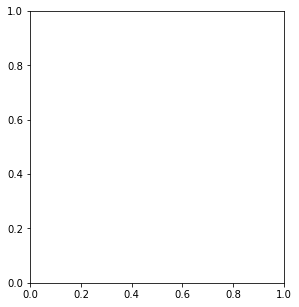

In [5]:
# plot summary of phase-reset results (mean +/- sem of z-values for theta, alpha,beta for C1 and C3)
fig = figure(figsize=[10,5])
C = get_cmap('tab10')
cidx = 7
useMeanRalZ = True
ev_list = ['wait','move']

foi = 'theta'
ax = subplot(1,2,1)
plot_errorbar_summary(S,ax,useMeanRalZ,foi,C.colors[cidx],ev_list = ev_list)

foi = 'beta'
ax = subplot(1,2,2)
plot_errorbar_summary(S,ax,useMeanRalZ,foi,C.colors[cidx],ev_list = ev_list)

tight_layout()
savefig('figs/synchrony.pdf',dpi = 150)

#foi = 'alpha'
#ax = subplot(5,1,2)
#plot_errorbar_summary(S,ax,useMeanRalZ,foi,C.colors[cidx],ev_list = ev_list)


#foi = 'gamma'
#ax = subplot(5,1,4)
#plot_errorbar_summary(S,ax,useMeanRalZ,foi,C.colors[cidx],ev_list = ev_list)


#foi = 'HFA'
#ax = subplot(5,1,5)
#plot_errorbar_summary(S,ax,useMeanRalZ,foi,C.colors[cidx],ev_list = ev_list)



In [13]:
# STATS
lbls_vec = [] 
p_vec=[] # for fdr correction
event_list =['move','wait']# ['move','inst','wait']
foi_list = ['theta','beta']


for e in arange(0,len(event_list)):
    event_type = event_list[e]

    print('::::::::::::::::'+event_type+'::::::::::::::::::::')
    print('Cluster 1 vs 3:')
    for f in arange(0,len(foi_list)):
        lbl = 'meanralz_'+event_type+'_'+foi_list[f]+'_post'
        lbl2 = 'meanralz_'+event_type+'_'+foi_list[f]+'_pre'
        [t,p] = stats.ttest_rel(getattr(S,lbl),getattr(S,lbl2))
        print((foi_list[f]+': pre vs post'),t,p)
        lbls_vec.append('S-'+lbl+'v_pre')
        p_vec = np.append(p_vec,p)

alfa = 0.05
[reject,p_val_corrected] = mne.stats.fdr_correction(p_vec,alfa)

idx = (p_val_corrected<=alfa).astype('bool')
print(np.array(lbls_vec)[idx])
print(p_val_corrected[idx])

::::::::::::::::move::::::::::::::::::::
Cluster 1 vs 3:
theta: pre vs post 2.964070169625634 0.006757697708728007
beta: pre vs post 1.5463901114163643 0.13509624121261307
::::::::::::::::wait::::::::::::::::::::
Cluster 1 vs 3:
theta: pre vs post 0.7906746175519869 0.43687784633255944
beta: pre vs post -0.3896954958626091 0.7001984775696212
['S-meanralz_move_theta_postv_pre']
[0.02703079]


In [193]:
theta_diff_move = S.meanralz_move_theta_post - S.meanralz_move_theta_pre
theta_diff_inst = S.meanralz_inst_theta_post - S.meanralz_inst_theta_pre
theta_diff_wait = S.meanralz_wait_theta_post - S.meanralz_wait_theta_pre

[t,p] = stats.ttest_rel(theta_diff_move,theta_diff_wait)
print(t,p)


beta_diff_move = S.meanralz_move_beta_post - S.meanralz_move_beta_pre
beta_diff_inst = S.meanralz_inst_beta_post - S.meanralz_inst_beta_pre
beta_diff_wait = S.meanralz_wait_beta_post - S.meanralz_wait_beta_pre

[t,p] = stats.ttest_rel(beta_diff_move,beta_diff_inst)
print(t,p)
[t,p] = stats.ttest_rel(S.ralz_move_theta_post,S.ralz_inst_theta_post)
print(t,p)

1.9038741662460263 0.06898410093126407
-1.8992591687908393 0.06961466519452245
5.191235431184315 3.714454260519046e-07


In [1]:
S.freq

NameError: name 'S' is not defined

In [7]:
%%capture
S = SynchronyGroup(EEG_c3,metadata_c3,EEG_c2,metadata_c2,params)
S.pairwise_synchrony()
S.calcMeanRalZ()

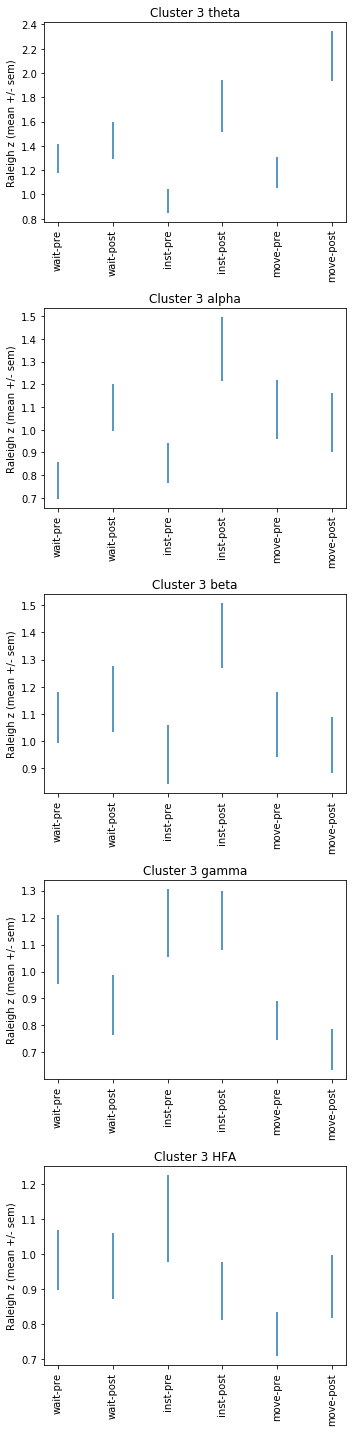

In [10]:
# plot summary of phase-reset results (mean +/- sem of z-values for theta, alpha,beta for C1 and C3)
fig = figure(figsize=[5,20])
C = get_cmap('tab10')
useMeanRalZ = True

foi = 'theta'
ax = subplot(5,1,1)
S.plot_errorbar_summary(ax,useMeanRalZ,foi,C.colors[0])

foi = 'alpha'
ax = subplot(5,1,2)
S.plot_errorbar_summary(ax,useMeanRalZ,foi,C.colors[0])

foi = 'beta'
ax = subplot(5,1,3)
S.plot_errorbar_summary(ax,useMeanRalZ,foi,C.colors[0])

foi = 'gamma'
ax = subplot(5,1,4)
S.plot_errorbar_summary(ax,useMeanRalZ,foi,C.colors[0])

foi = 'HFA'
ax = subplot(5,1,5)
S.plot_errorbar_summary(ax,useMeanRalZ,foi,C.colors[0])

tight_layout()